### Задание по статистике

Дан датасет (https://www.kaggle.com/karangadiya/fifa19#data.csv), представляющий из себя детальную аналитику всех игроков FIFA 2019. Необходимо проверить следующие гипотезы с помощью статистических критериев:

- Игровой рейтинг (поле Overall) "левшей" (поле Preferred Foot) больше рейтинга "правшей".
- Средний игровой рейтинг игроков из Аргентины, Англии и Германии (поле Nationality) одинаков. 

Провести первичный анализ данных. Сформулировать нулевую и альтернативную гипотезу. Использовать правильные статистические критерии для проверки гипотез. Каждый шаг должен сопровождаться комментариями (если используете параметрический критерий, обязательно показывать, что его использование допустимо и корректно) и графиками, где это необходимо, должны быть сделаны статистические выводы. 

In [1]:
import pandas as pd
import json
import numpy as np
import statsmodels.api as sms
import matplotlib.pyplot as plt
from scipy import stats
import tqdm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.model_selection import TimeSeriesSplit
from pylab import rcParams
from sklearn.metrics import mean_absolute_error as mae
import warnings
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)

# Предисловие и загрузка датасета

Датасет взят с ресурса Kaggle: https://www.kaggle.com/karangadiya/fifa19. data.csv includes lastest edition FIFA 2019 players attributes.

В нём содержаться игроки в игре FIFA 2019 в том смысле, что этими "персонажами" можно играть в игре. ( Не путать с самими игроками в игру, их, безусловно, в разы больше )

In [3]:
df = pd.read_csv('data.csv')
df

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [4]:
df.describe()

,Unnamed: 0,ID,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Jersey Number,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,18159.000000,18159.000000,18159.000000,18147.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,9103.000000,214298.338606,25.122206,66.238699,71.307299,1597.809908,1.113222,2.947299,2.361308,19.546096,49.734181,45.550911,52.298144,58.686712,42.909026,55.371001,47.170824,42.863153,52.711933,58.369459,64.614076,64.726967,63.503607,61.836610,63.966573,55.460047,65.089432,63.219946,65.311967,47.109973,55.868991,46.698276,49.958478,53.400903,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,5256.052511,29965.244204,4.669943,6.908930,6.136496,272.586016,0.394031,0.660456,0.756164,15.947765,18.364524,19.525820,17.379909,14.699495,17.694408,18.910371,18.395264,17.478763,15.327870,16.686595,14.927780,14.649953,14.766049,9.010464,14.136166,17.237958,11.820044,15.894741,12.557000,19.260524,17.367967,20.696909,19.529036,14.146881,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,0.000000,16.000000,16.000000,46.000000,48.000000,731.000000,1.000000,1.000000,1.000000,1.000000,5.000000,2.000000,4.000000,7.000000,4.000000,4.000000,6.000000,3.000000,9.000000,5.000000,12.000000,12.000000,14.000000,21.000000,16.000000,2.000000,15.000000,12.000000,17.000000,3.000000,11.000000,3.000000,2.000000,10.000000,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4551.500000,200315.500000,21.000000,62.000000,67.000000,1457.000000,1.000000,3.000000,2.000000,8.000000,38.000000,30.000000,44.000000,54.000000,30.000000,49.000000,34.000000,31.000000,43.000000,54.000000,57.000000,57.000000,55.000000,56.000000,56.000000,45.000000,58.000000,56.000000,58.000000,33.000000,44.000000,26.000000,38.000000,44.000000,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,9103.000000,221759.000000,25.000000,66.000000,71.000000,1635.000000,1.000000,3.000000,2.000000,17.000000,54.000000,49.000000,56.000000,62.000000,44.000000,61.000000,48.000000,41.000000,56.000000,63.000000,67.000000,67.000000,66.000000,62.000000,66.000000,59.000000,66.000000,66.000000,67.000000,51.000000,59.000000,52.000000,55.000000,55.000000,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,13654.500000,236529.500000,28.000000,71.000000,75.000000,1787.000000,1.000000,3.000000,3.000000,26.000000,64.000000,62.000000,64.000000,68.000000,57.000000,68.000000,62.000000,57.000000,64.000000,69.000000,75.000000,75.000000,74.000000,68.000000,74.000000,68.000000,73.000000,74.000000,74.000000,62.000000,69.000000,64.000000,64.000000,64.000000,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,18206.000000,246620.000000,45.000000,94.000000,95.000000,2346.000000,5.000000,5.000000,5.000000,99.000000,93.000000,95.000000,94.000000,93.000000,90.000000,97.000000,94.000000,94.000000,93.000000,96.000000,97.000000,96.000000,96.000000,96.000000,96.000000,95.000000,95.000000,96.000000,97.000000,94.000

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18207 non-null  int64  
 1   ID                        18207 non-null  int64  
 2   Name                      18207 non-null  object 
 3   Age                       18207 non-null  int64  
 4   Photo                     18207 non-null  object 
 5   Nationality               18207 non-null  object 
 6   Flag                      18207 non-null  object 
 7   Overall                   18207 non-null  int64  
 8   Potential                 18207 non-null  int64  
 9   Club                      17966 non-null  object 
 10  Club Logo                 18207 non-null  object 
 11  Value                     18207 non-null  object 
 12  Wage                      18207 non-null  object 
 13  Special                   18207 non-null  int64  
 14  Prefer

# Первичный  и визуальный анализ данных

Рассмотрим каждый стобец, его значимость с поянениями и будем удалять по ходу дела большинство столбцов, которые в данном
задании не несут полезной информации.

Отмечу, что, естественно, датасет юзабелен и в плане столбцов, которые я в дальнейшем дропаю. Можно придумать интересные гипотезы касательно клубов, возраста игроков, множества стран, присутствующих в датасете и т д.
Можно даже провести более глубокий анализ касательно большого количества личных характеристик, FIFA всё-таки довольно
многогранная игра на уровне Dota и Hearthstone. 

Но, повторюсь, данные возможные исследования могут потянуть на целый отдельный минипроект, поэтому их на данный момент оставим за кадром.

In [6]:
df

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

Колонка Photo - по видимому, фотографии игроков ( почему-то при переходе по ссылке не открываются).

В любом случае, - столбец бесполезный, поэтому drop.

In [7]:
df = df.drop(['Photo'], axis = 1 )

Flag - аналогичная ситуация, как и с фото. Скорее всего, это просто фотографии стран, за которые футболисты выступают.

In [8]:
df = df.drop(['Flag'], axis = 1 )

Club Logo - аналогично, фотография клуба, за который выступают игроки, тоже дроп.

In [9]:
df = df.drop(['Club Logo'], axis = 1 )

Value and Wage - По видимому, Wage - это зарплата игрока, а Value - стоимость покупки в свой клуб в самой игре.

In [10]:
df = df.drop(['Wage'], axis = 1 )
df = df.drop(['Value'], axis = 1 )

Club - клубы игроков. Я думаю, данный столбец открывает много возможностей для создания и проверки гипотез, уж очень большое количество клубов он содержит

In [11]:
df.Club.unique().shape

(652,)

Как мы видим, клубов аж целых 652! Тем не менее, в данном задании тоже дропнем этот столбец

In [12]:
df = df.drop(['Club'], axis = 1 )

Special - не очень понятный столбец, просто исключим его.

In [13]:
df = df.drop(['Special'], axis = 1 )

International Reputation - возможно это международная репутация (по прямому переводу с английского) игрока.

Мол, если какой - нибудь игрок ведёт себя как два всеми известных русских футболиста ( не будем называть их имена и фамилии),
то разработчики в игре добавили ему плохой рейтинг. Или какой-то иной фактор.

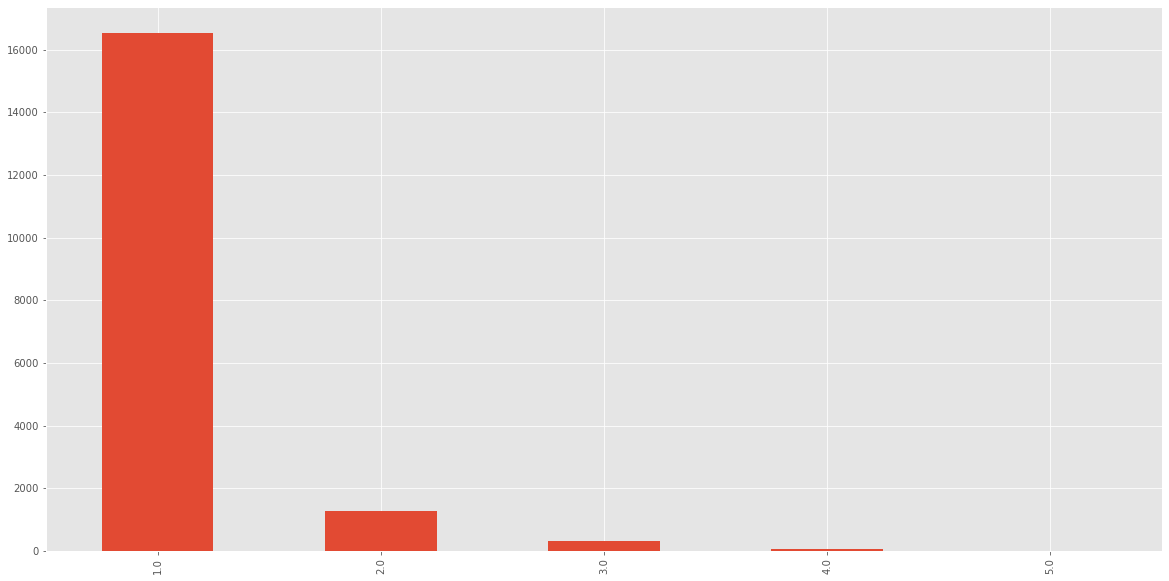

In [14]:
fig = plt.figure(figsize= (20,10))
df['International Reputation'].value_counts().plot.bar()

А вообще, провизуализировав этот столбец, мы видим довольно странную картину. Такое ощущение, что 1 - это самый лучший рейтинг, а 5 - самый худший.

Так можно было бы сказать, если бы Messi, Cristiano Ronaldo и Neymar Jr не имели рейтинги под 4-5. А они самые топовые игроки, если что. Поэтому, мне не очень понятна статистика по этому столбцу. Мол, у большинства рейтинг 1 , это значит, что они самые обычные игроки и просто ещё пока не такие знаменитые? Тогда этот рейтинг не отражает сути репутации, и какой-то плохой репутации вообще, по-видимому, нет. В общем, странно

In [15]:
df = df.drop(['International Reputation'], axis = 1 )

Body Type - очень весёлый столбец, ладно бы Normal,ок. Lean - по идее опорник( В FIFA почти не играл, по догадкам анализирую ).
Но что там делает Тип тела: Messi, Neymar и т д - загадка :D

In [16]:
df = df.drop(['Body Type'], axis = 1 )

Loaned From - столбец NaNов, удаляем.

In [17]:
df = df.drop(['Loaned From'], axis = 1 )

Столбцы Height Weight - Рост и вес. Тоже хорошие столбцы для создания и проверки гипотез ( парочка сразу в голову лезет). Но, опять же, сейчас удаляем

In [18]:
df = df.drop(['Height'], axis = 1 )
df = df.drop(['Weight'], axis = 1 )

Jersey Number - какой то футбольный термин, не разбираюсь, удаляем.

In [19]:
df = df.drop(['Jersey Number'], axis = 1 )

Real Face - что то странное, удаляем

In [20]:
df = df.drop(['Real Face'], axis = 1 )

Joined - столбец = дата присоединения к клубу.

In [21]:
df = df.drop(['Joined'], axis = 1 )

Contract Valid Until - понятно по названию, в каком году заканчивается подписанный контракт игрока с клубом.

In [22]:
df = df.drop(['Contract Valid Until'], axis = 1 )

Weak Foot - какой то футбольный термин, не разбираюсь, ничего сказать не смогу

In [23]:
df = df.drop(['Weak Foot'], axis = 1 )

Work Rate -  не очень понимаю, что это. Пропустим.

In [24]:
df = df.drop(['Work Rate'], axis = 1 )

Следующие блоки, судя по всему, составляют суммарно по какому-то пересчёту Overall для каждого игрока.

И каждый из этих столбцов даёт свой вклад. Но отдельно мы их никак не анализируем - поэтому удалим и будем оценивать лишь Overall

In [25]:
df = df.drop(['LS'], axis = 1 )
df = df.drop(['ST'], axis = 1 )
df = df.drop(['RS'], axis = 1 )
df = df.drop(['LW'], axis = 1 )
df = df.drop(['LF'], axis = 1 )
df = df.drop(['CF'], axis = 1 )
df = df.drop(['RF'], axis = 1 )
df = df.drop(['RW'], axis = 1 )
df = df.drop(['LAM'], axis = 1 )
df = df.drop(['CAM'], axis = 1 )
df = df.drop(['RAM'], axis = 1 )
df = df.drop(['LM'], axis = 1 )
df = df.drop(['LCM'], axis = 1 )
df = df.drop(['CM'], axis = 1 )
df = df.drop(['RCM'], axis = 1 )
df = df.drop(['RM'], axis = 1 )
df = df.drop(['LWB'], axis = 1 )
df = df.drop(['CDM'], axis = 1 )
df = df.drop(['RDM'], axis = 1 )
df = df.drop(['RWB'], axis = 1 )
df = df.drop(['LB'], axis = 1 )
df = df.drop(['LCB'], axis = 1 )
df = df.drop(['CB'], axis = 1 )
df = df.drop(['RCB'], axis = 1 )
df = df.drop(['RB'], axis = 1 )
df = df.drop(['LDM'], axis = 1 )

Следующие характеристики более понятны по названию, но опять же, произведём их удаление

In [26]:
df = df.drop(['Crossing'], axis = 1 )
df = df.drop(['Finishing'], axis = 1 )
df = df.drop(['HeadingAccuracy'], axis = 1 )
df = df.drop(['ShortPassing'], axis = 1 )
df = df.drop(['Volleys'], axis = 1 )
df = df.drop(['Dribbling'], axis = 1 )
df = df.drop(['Curve'], axis = 1 )
df = df.drop(['FKAccuracy'], axis = 1 )
df = df.drop(['LongPassing'], axis = 1 )
df = df.drop(['BallControl'], axis = 1 )
df = df.drop(['Acceleration'], axis = 1 )
df = df.drop(['SprintSpeed'], axis = 1 )
df = df.drop(['Agility'], axis = 1 )
df = df.drop(['Reactions'], axis = 1 )
df = df.drop(['Balance'], axis = 1 )
df = df.drop(['ShotPower'], axis = 1 )
df = df.drop(['Jumping'], axis = 1 )
df = df.drop(['Stamina'], axis = 1 )
df = df.drop(['Strength'], axis = 1 )
df = df.drop(['LongShots'], axis = 1 )
df = df.drop(['Aggression'], axis = 1 )
df = df.drop(['Interceptions'], axis = 1 )
df = df.drop(['Positioning'], axis = 1 )
df = df.drop(['Vision'], axis = 1 )
df = df.drop(['Penalties'], axis = 1 )
df = df.drop(['Composure'], axis = 1 )
df = df.drop(['Marking'], axis = 1 )
df = df.drop(['StandingTackle'], axis = 1 )
df = df.drop(['SlidingTackle'], axis = 1 )
df = df.drop(['GKDiving'], axis = 1 )
df = df.drop(['GKHandling'], axis = 1 )
df = df.drop(['GKKicking'], axis = 1 )
df = df.drop(['GKPositioning'], axis = 1 )
df = df.drop(['GKReflexes'], axis = 1 )
df = df.drop(['Release Clause'], axis = 1 )

In [27]:
df

,Unnamed: 0,ID,Name,Age,Nationality,Overall,Potential,Preferred Foot,Skill Moves,Position
0,0,158023,L. Messi,31,Argentina,94,94,Left,4.0,RF
1,1,20801,Cristiano Ronaldo,33,Portugal,94,94,Right,5.0,ST
2,2,190871,Neymar Jr,26,Brazil,92,93,Right,5.0,LW
3,3,193080,De Gea,27,Spain,91,93,Right,1.0,GK
4,4,192985,K. De Bruyne,27,Belgium,91,92,Right,4.0,RCM
...,...,...,...,...,...,...,...,...,...,...
18202,18202,238813,J. Lundstram,19,England,47,65,Right,2.0,CM
18203,18203,243165,N. Christoffersson,19,Sweden,47,63,Right,2.0,ST
18204,18204,241638,B. Worman,16,England,47,67,Right,2.0,ST
18205,18205,246268,D. Walker-Rice,17,England,47,66,Right,2.0,RW


Итак, остались более менее существенные колонки, но тем не менее, проведём анализ до конца

Не очень понятно, что такое Potential, очень похоже на Overall, возможно это максимальный скор, который футболист
может достигнуть. Дропну, ведь в задании всё равно надо работать с Overall

In [28]:
df = df.drop(['Potential'], axis = 1 )

Position - интересная метка, тоже пригодилась бы в будущем, возможно.

In [29]:
df = df.drop(['Position'], axis = 1 )

In [30]:
df

,Unnamed: 0,ID,Name,Age,Nationality,Overall,Preferred Foot,Skill Moves
0,0,158023,L. Messi,31,Argentina,94,Left,4.0
1,1,20801,Cristiano Ronaldo,33,Portugal,94,Right,5.0
2,2,190871,Neymar Jr,26,Brazil,92,Right,5.0
3,3,193080,De Gea,27,Spain,91,Right,1.0
4,4,192985,K. De Bruyne,27,Belgium,91,Right,4.0
...,...,...,...,...,...,...,...,...
18202,18202,238813,J. Lundstram,19,England,47,Right,2.0
18203,18203,243165,N. Christoffersson,19,Sweden,47,Right,2.0
18204,18204,241638,B. Worman,16,England,47,Right,2.0
18205,18205,246268,D. Walker-Rice,17,England,47,Right,2.0


Age - возраст, тоже огромное поле для анализа.

In [31]:
df_age = df.sort_values(by=['Age'], ascending = True)

In [32]:
df_age

,Unnamed: 0,ID,Name,Age,Nationality,Overall,Preferred Foot,Skill Moves
18206,18206,246269,G. Nugent,16,England,46,Right,2.0
17743,17743,244752,J. Olstad,16,Norway,52,Right,2.0
13293,13293,246594,H. Massengo,16,France,62,Right,2.0
16081,16081,241552,J. Italiano,16,Australia,58,Right,3.0
18166,18166,243621,N. Ayéva,16,Sweden,48,Right,2.0
...,...,...,...,...,...,...,...,...
12192,12192,208927,H. Sulaimani,41,Saudi Arabia,63,Left,3.0
10545,10545,140183,S. Narazaki,42,Japan,65,Right,1.0
18183,18183,53748,K. Pilkington,44,England,48,Right,1.0
17726,17726,51963,T. Warner,44,Trinidad & Tobago,53,Right,1.0


Визуализируем гистограмму игроков в зависимости от возраста.

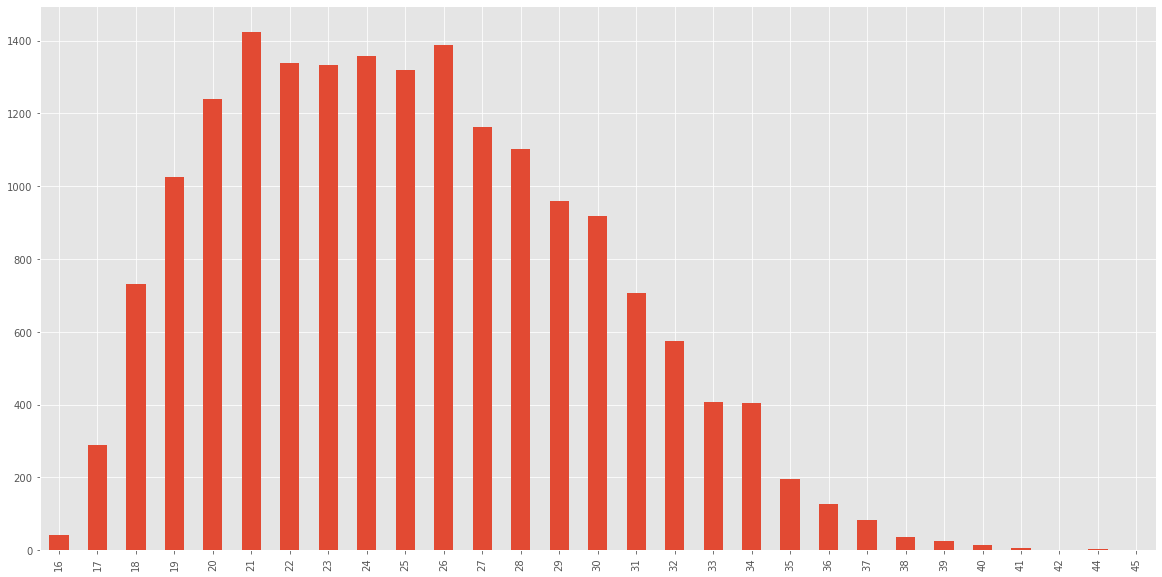

In [33]:
fig = plt.figure(figsize= (20,10))
df_age['Age'].value_counts().sort_index().plot.bar()

Интересно, является ли это распределение нормальным, давайте для формальности проверим.

Критерий Шапиро-Уилка:

$H_0\colon$ Распределение возраста игроков нормально.

$H_1\colon$ не нормально.

In [34]:
stats.shapiro(np.array(df['Age']))

ShapiroResult(statistic=0.9751392006874084, pvalue=0.0)

Как мы видим, pvalue равно нулю. Мы не можем принять нулевую гипотезу. Поэтому, увы, не нормально (Если я конечно не накосячил с применением теста). Впрочем, к заданию это не относится, поэтому пойдём дальше

In [35]:
df = df.drop(['Age'], axis = 1 )

In [36]:
df

,Unnamed: 0,ID,Name,Nationality,Overall,Preferred Foot,Skill Moves
0,0,158023,L. Messi,Argentina,94,Left,4.0
1,1,20801,Cristiano Ronaldo,Portugal,94,Right,5.0
2,2,190871,Neymar Jr,Brazil,92,Right,5.0
3,3,193080,De Gea,Spain,91,Right,1.0
4,4,192985,K. De Bruyne,Belgium,91,Right,4.0
...,...,...,...,...,...,...,...
18202,18202,238813,J. Lundstram,England,47,Right,2.0
18203,18203,243165,N. Christoffersson,Sweden,47,Right,2.0
18204,18204,241638,B. Worman,England,47,Right,2.0
18205,18205,246268,D. Walker-Rice,England,47,Right,2.0


Не знаю, что такое Skill Moves, но было бы интересно взглянуть на распределение игроков по этому параметру

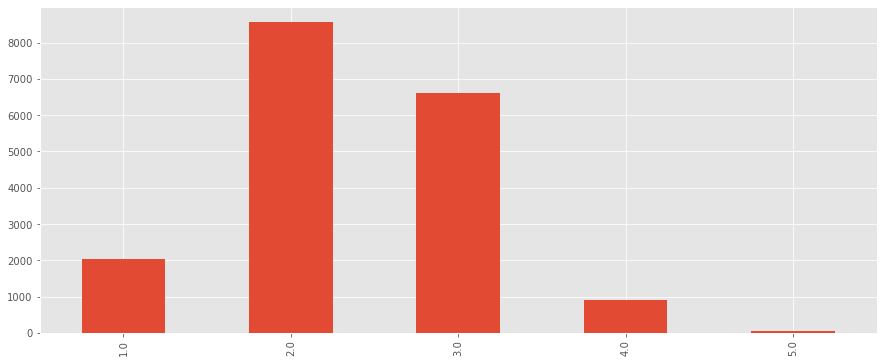

In [37]:
fig = plt.figure(figsize= (15,6))
df_age['Skill Moves'].value_counts().sort_index().plot.bar()

In [38]:
df = df.drop(['Skill Moves'], axis = 1 )

In [39]:
df

,Unnamed: 0,ID,Name,Nationality,Overall,Preferred Foot
0,0,158023,L. Messi,Argentina,94,Left
1,1,20801,Cristiano Ronaldo,Portugal,94,Right
2,2,190871,Neymar Jr,Brazil,92,Right
3,3,193080,De Gea,Spain,91,Right
4,4,192985,K. De Bruyne,Belgium,91,Right
...,...,...,...,...,...,...
18202,18202,238813,J. Lundstram,England,47,Right
18203,18203,243165,N. Christoffersson,Sweden,47,Right
18204,18204,241638,B. Worman,England,47,Right
18205,18205,246268,D. Walker-Rice,England,47,Right


In [40]:
NumOfPlayers = df.ID.unique()
NumOfPlayers.shape

(18207,)

Как мы видим, все ID-шники игроков уникальные, что позволяет считать, что у нас нет дубликатов и можно смело без наличия  выбросов проводить анализ.

Но отмечу одну странность, замеченную мной: 

In [41]:
Names = df.Name.unique()
Names.shape

(17194,)

В отличие от честных ID-шников, если брать уникальные элементы по именам - их где-то на тысячу меньше. 

Довольно странно, но предположим, что есть несколько игроков с одинаковым именем, но разными характеристиками.
Всё-таки не будут же выкладывать на Kaggle в общий доступ датасет с выбросами или плохими данными(учитывая количества обсуждений вокруг этого датасета )

# Выполнение задания

### Задание 1. Игровой рейтинг (поле Overall) "левшей" (поле Preferred Foot) больше рейтинга "правшей".

Посмотрим соотношения левшей и правшей

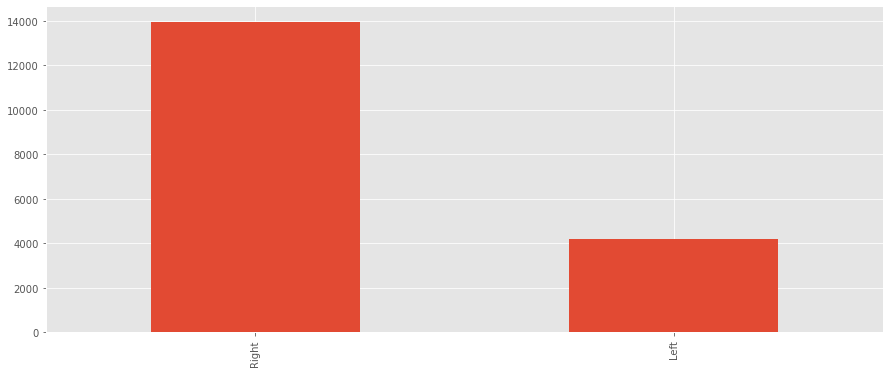

In [42]:
fig = plt.figure(figsize= (15,6))
df['Preferred Foot'].value_counts().plot.bar()

Посмотрим точное количество левшей и правшей

In [43]:
df[df['Preferred Foot'] == 'Right'].shape[0]

13948

In [44]:
df[df['Preferred Foot'] == 'Left'].shape[0]

4211

Как мы видим, количество правшей где-то в 3,5 раза больше кол-ва левшей ( что логично)

По сути, мы имеем одну общую генеральную совокупность из игроков FIFA 2019.

Извлекая выборку с игроками-левшами и игроками-правшами, мы получим две независимые выборки, совершенно никак не связанные друг с другом. И всё, что нам нужно сделать - это проверить как отличаются средние Overall игроков, с учётом размера выборок и их разбросов.

In [45]:
df_left = df[df['Preferred Foot'] == 'Left']
df_left

,Unnamed: 0,ID,Name,Nationality,Overall,Preferred Foot
0,0,158023,L. Messi,Argentina,94,Left
13,13,168542,David Silva,Spain,90,Left
15,15,211110,P. Dybala,Argentina,89,Left
17,17,194765,A. Griezmann,France,89,Left
19,19,192119,T. Courtois,Belgium,89,Left
...,...,...,...,...,...,...
18172,18172,243636,C. Hawkins,England,48,Left
18175,18175,243649,E. Clarke,England,48,Left
18191,18191,245570,J. Norville-Williams,England,47,Left
18200,18200,231381,J. Young,Scotland,47,Left


In [46]:
df_right = df[df['Preferred Foot'] == 'Right']
df_right

,Unnamed: 0,ID,Name,Nationality,Overall,Preferred Foot
1,1,20801,Cristiano Ronaldo,Portugal,94,Right
2,2,190871,Neymar Jr,Brazil,92,Right
3,3,193080,De Gea,Spain,91,Right
4,4,192985,K. De Bruyne,Belgium,91,Right
5,5,183277,E. Hazard,Belgium,91,Right
...,...,...,...,...,...,...
18202,18202,238813,J. Lundstram,England,47,Right
18203,18203,243165,N. Christoffersson,Sweden,47,Right
18204,18204,241638,B. Worman,England,47,Right
18205,18205,246268,D. Walker-Rice,England,47,Right


In [47]:
Overall_left = np.array(df_left.Overall)
Overall_left.shape

(4211,)

In [48]:
Overall_right = np.array(df_right.Overall)
Overall_right.shape

(13948,)

Таким образом, исходя из вышесказанного, я воспользуюсь двумя критериями.

Параметрический - Критерий Стьюдента и непараметрический - критерий Манна-Уитни, оба для независимых выборок.

Сформулируем нулевую и альтернативную гипотезы

H0: Среднее значение Overall для левшей и правшей одинаково

H1: Среднее значение Overall для левшей и правшей отличается

Для начала, воспользуемся такой постановкой и проверим разницу, применяя оба этих критерия

In [49]:
t_stat = stats.ttest_ind(Overall_right,Overall_left)
t_stat

Ttest_indResult(statistic=-5.911803381927974, pvalue=3.444411292721854e-09)

In [50]:
stats.mannwhitneyu(Overall_right,Overall_left)

MannwhitneyuResult(statistic=27693265.5, pvalue=9.468043989128382e-09)

Как мы видим, оба критерия дают p-value в порядке 10 в -9, а это значит, что нулевая гипотеза отвергается - средние значения Overall для этих выборок ( левшей и правшей) разные.

Этап 2. Нужно проверить, а у кого же больше? Для этого воспользуемся в этих критериях альтернативой 'greater'. Сформулируем в данном случае нулевую и альтернативную гипотезы

H0: Среднее значение Overall для левшей больше, чем для правшей

H1: Среднее значение Overall для правшей больше, чем для левшей ( альтернатива именно такая, ибо мы уже проверили гипотезу о равенстве и отклонили её)

In [51]:
t_stat = stats.ttest_ind(Overall_right,Overall_left,alternative='greater')
t_stat

Ttest_indResult(statistic=-5.911803381927974, pvalue=0.9999999982777943)

In [52]:
stats.mannwhitneyu(Overall_right,Overall_left, alternative = 'greater')

MannwhitneyuResult(statistic=27693265.5, pvalue=0.9999999905321401)

Как мы видим, мы не можем отклонить нулевую гипотезу, а значит, вывод: игровой рейтинг Overall футболистов левшей больше, чем у футболистов правшей

### Задание 2. Средний игровой рейтинг игроков из Аргентины, Англии и Германии (поле Nationality) одинаков.

In [53]:
df

,Unnamed: 0,ID,Name,Nationality,Overall,Preferred Foot
0,0,158023,L. Messi,Argentina,94,Left
1,1,20801,Cristiano Ronaldo,Portugal,94,Right
2,2,190871,Neymar Jr,Brazil,92,Right
3,3,193080,De Gea,Spain,91,Right
4,4,192985,K. De Bruyne,Belgium,91,Right
...,...,...,...,...,...,...
18202,18202,238813,J. Lundstram,England,47,Right
18203,18203,243165,N. Christoffersson,Sweden,47,Right
18204,18204,241638,B. Worman,England,47,Right
18205,18205,246268,D. Walker-Rice,England,47,Right


Обработаем и визуализируем данные для каждой страны

In [54]:
Argentina = df[df['Nationality'] == 'Argentina']
Argentina

,Unnamed: 0,ID,Name,Nationality,Overall,Preferred Foot
0,0,158023,L. Messi,Argentina,94,Left
15,15,211110,P. Dybala,Argentina,89,Left
23,23,153079,S. Agüero,Argentina,89,Right
38,38,167664,G. Higuaín,Argentina,88,Right
43,43,201399,M. Icardi,Argentina,87,Right
...,...,...,...,...,...,...
17349,17349,240955,T. Durso,Argentina,54,Right
17355,17355,237125,V. Barbero,Argentina,54,Right
17638,17638,236431,E. Alarcón,Argentina,53,Right
17861,17861,245726,F. Bustamante,Argentina,52,Right


In [55]:
England = df[df['Nationality'] == 'England']
England

,Unnamed: 0,ID,Name,Nationality,Overall,Preferred Foot
16,16,202126,H. Kane,England,89,Right
60,60,202652,R. Sterling,England,86,Right
117,117,211117,D. Alli,England,84,Right
135,135,188377,K. Walker,England,84,Right
180,180,204935,J. Pickford,England,83,Left
...,...,...,...,...,...,...
18198,18198,242844,J. Livesey,England,47,Right
18202,18202,238813,J. Lundstram,England,47,Right
18204,18204,241638,B. Worman,England,47,Right
18205,18205,246268,D. Walker-Rice,England,47,Right


In [56]:
Germany = df[df['Nationality'] == 'Germany']
Germany

,Unnamed: 0,ID,Name,Nationality,Overall,Preferred Foot
11,11,182521,T. Kroos,Germany,90,Right
18,18,192448,M. ter Stegen,Germany,89,Right
22,22,167495,M. Neuer,Germany,89,Right
34,34,178603,M. Hummels,Germany,88,Right
55,55,222492,L. Sané,Germany,86,Left
...,...,...,...,...,...,...
18101,18101,243934,J. Hipper,Germany,50,Right
18127,18127,244043,N. Stephan,Germany,49,Right
18145,18145,244172,M. Harsman,Germany,49,Right
18187,18187,240158,C. Ehlich,Germany,47,Right


In [57]:
ArgentinaOverall = np.array(Argentina.Overall)
ArgentinaOverall.shape

(937,)

In [58]:
EnglandOverall = np.array(England.Overall)
EnglandOverall.shape

(1662,)

In [59]:
GermanyOverall = np.array(Germany.Overall)
GermanyOverall.shape

(1198,)

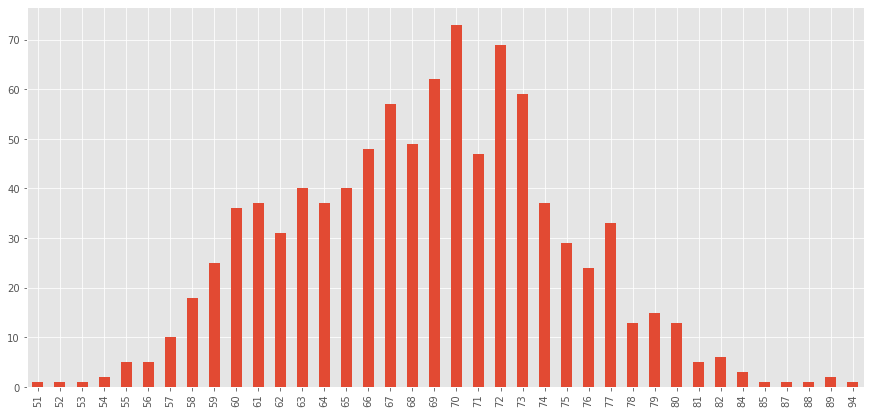

In [60]:
fig = plt.figure(figsize= (15,7))
Argentina['Overall'].value_counts(sort = False).plot.bar()

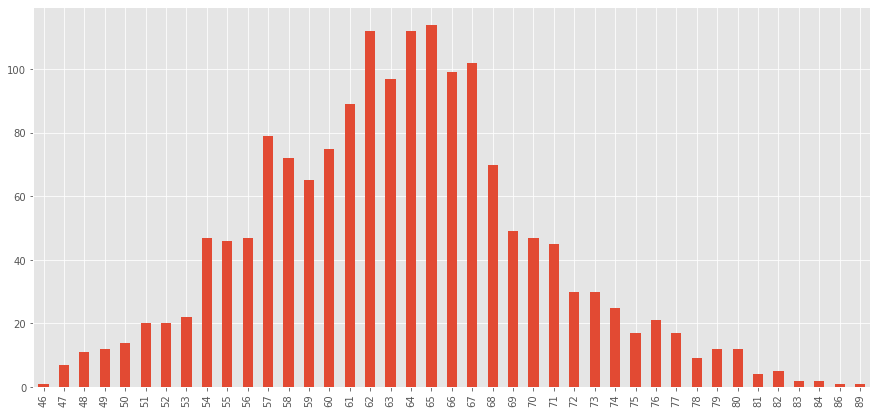

In [61]:
fig = plt.figure(figsize= (15,7))
England['Overall'].value_counts(sort = False).plot.bar()

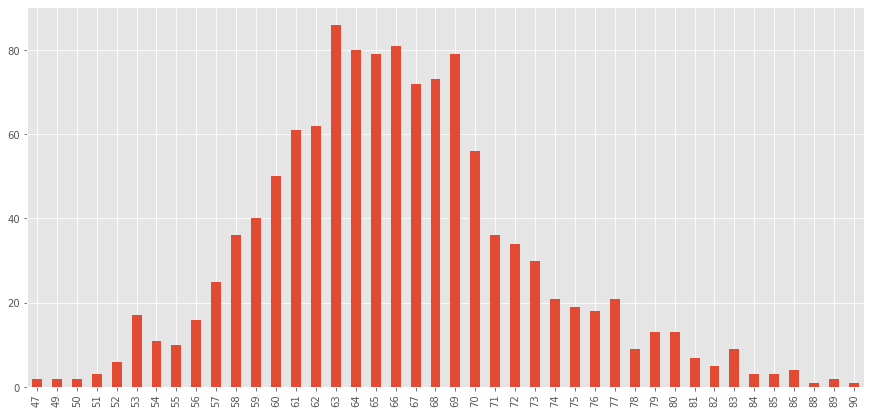

In [62]:
fig = plt.figure(figsize= (15,7))
Germany['Overall'].value_counts(sort = False).plot.bar()

Визуально, не очень понятно, чей же рейтинг преобладает

По аналогии с заданием из рубежного контроля, воспользуемся попарными сравнениями средних с использованием непараметрического критерия для независимых групп Манна-Уитни. ( Не зря же нам кидали разбор этого задания, где явно указали на него, здесь он подходит идеально)

У нас три независимые выборки, - игроки Англии, Германии и Аргентины. Наша задача, проверить средний рейтинг - полная аналогия

Задаём уровень значимости 1%

Формулируем три гипотезы H0 и три альтернативных гипотезы H1

<U>1 группа:</U>

H0: средний рейтинг у игроков Аргентины и Англии одинаковый

H1: средний рейтинг у игроков Аргентины и Англии отличается
    
<U>2 группа:</U>

H0: средний рейтинг у игроков Аргентины и Германии одинаковый
    
H1: средний рейтинг у игроков Аргентины и Германии отличается
    
    
<U>3 группа:</U>

H0: средний рейтинг у игроков Англии и Германии одинаковый
    
H1: средний рейтинг у игроков Англии и Германии отличается    

In [63]:
stats.mannwhitneyu(ArgentinaOverall, EnglandOverall)

MannwhitneyuResult(statistic=442172.5, pvalue=2.1695329191349672e-75)

In [64]:
stats.mannwhitneyu(ArgentinaOverall, GermanyOverall)

MannwhitneyuResult(statistic=426158.0, pvalue=5.408065915956872e-22)

In [65]:
stats.mannwhitneyu(EnglandOverall, GermanyOverall)

MannwhitneyuResult(statistic=777088.0, pvalue=5.1983501658344504e-24)

Делаем поправку на множественные сравнения ( например поправку Бонферрони). Наш уровень значимости был 1%. В случае групп k=3, поправка влияет на уровень значимости следующим образом: вместо 1% мы берём уровень значимости равный 1/3, то есть - теперь мы принимаем нулевую гипотезу в случае, если Pvalue >= 0.033. 

Однако, если мы заметим, что вообще за pvalue у нас получились, хоть мы возьмём уровень значимости равный 0.000033, всё равно, наша нулевая гипотеза отклоняется во всех трёх случаях, ибо pvalue во всех случаях - маленькое число с порядком малости 10 в -75, в -22 и -24 степенях соответственно. Из чего можно сделать следующие выводы:

Нулевая гипотеза отклоняется во всех трёх случаях, что обозначает, что средний рейтинг игроков из Аргентины, Англии и Германии разный во всех странах. Нет ни одной совпадающей по рейтингу пары, игроки каждой страны в среднем отличаются.